Configurations

In [ ]:
import sys
sys.path.append('../')
import torch
from torch import nn
from matplotlib import collections  as mc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython.display import clear_output
from src.cost import strong_cost
from src.toy import *
from src.utils import *
import os

CONFIG = Config()

CONFIG.GPU_DEVICE = 0
assert torch.cuda.is_available()
CONFIG.DEVICE = f'cuda:{CONFIG.GPU_DEVICE}'

CONFIG.K = 3  # amount of distributions
CONFIG.LAMBDAS = [0.3333, 0.3333, 0.3333]
CONFIG.DIM = 2
CONFIG.INPUT_DIM = CONFIG.DIM
CONFIG.HIDDEN_DIMS = [256,256]
CONFIG.OUTPUT_DIM_POT = 1
CONFIG.OUTPUT_DIM_MAP = CONFIG.DIM
CONFIG.LR = 1e-3
CONFIG.NUM_SAMPLES = 10_000
CONFIG.NUM_EPOCHS = 20000
CONFIG.BATCH_SIZE= 256
CONFIG.INNER_ITERATIONS = 5

###### IMPORTANT HYPERPARAMETERS
CONFIG.DIVERGENCE = 'kl'
CONFIG.OUTLIER = 0.05
CONFIG.TAU = 1

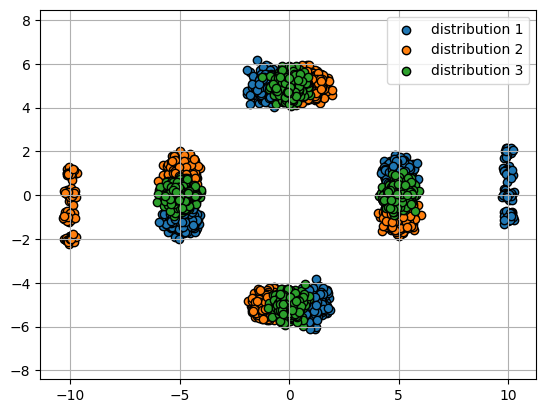

In [3]:
# define data
import torch.distributions as td
from src.data import ToySampler
import math

class GaussianOutlier:
    def __init__(self, mus, props, sigmas):
        assert len(mus) == len(props) == len(sigmas)

        # build mu's and sigma's
        dim = len(mus[0])
        mus = [torch.Tensor(mu) for mu in mus]
        sigmas = [sigmas[i]*torch.eye(dim) for i in range(len(mus))]
        self.props = np.array(props) / sum(props)

        self.num = len(mus)
        self.dists=[
            td.multivariate_normal.MultivariateNormal(mu, sigma) for mu, sigma in zip(mus, sigmas)
        ]

    def sample(self, n):
        n = n[0]
        dist_idx = np.random.choice(self.num, n, p=self.props)
        dist_unique, dist_freq = np.unique(dist_idx, return_counts=True)
        samples = [self.dists[dist_unique_].sample([dist_freq_]) for dist_unique_, dist_freq_ in zip(dist_unique, dist_freq)]
        # samples=[dist.sample([int(ind_sample)]) for dist in self.dists]
        samples=torch.cat(samples,dim=0)
        return samples

# With Outlier
if CONFIG.OUTLIER > 0:
    outlier1 = [[-10,1], [-10,0], [-10,-1], [-10,-2]]
    outlier2 = [[10,2], [10,1], [10,0], [10,-1]]
    outlier1_prop = [CONFIG.OUTLIER]*len(outlier1)
    outlier2_prop = [CONFIG.OUTLIER]*len(outlier2)
    std1 = [0.02]*len(outlier1)
    std2 = [0.02]*len(outlier2)

# # Without Outlier
else:
    outlier1 = []
    outlier2 = []
    outlier1_prop = []
    outlier2_prop = []
    std1 = []
    std2 = []


dataset1 = GaussianOutlier([[-5,-1],[5,1], [1,-5], [-1,5]]+outlier2, 
                           [1, 1, 1, 1]+outlier2_prop, 
                           [0.1, 0.1, 0.1, 0.1]+std2)
dataset2 = GaussianOutlier([[-5,1],[5,-1],[1,5],[-1,-5]]+outlier1, 
                           [1, 1, 1, 1]+outlier1_prop, 
                           [0.1, 0.1, 0.1, 0.1]+std1)
dataset3 = GaussianOutlier([[-5,0],[5,0],[0,5],[0,-5]], 
                           [1, 1, 1, 1], 
                           [0.1, 0.1, 0.1, 0.1])
sampler1 = ToySampler(dataset1)
sampler2 = ToySampler(dataset2)
sampler3 = ToySampler(dataset3)
datas = [sampler1, sampler2, sampler3]

def plot_initial_data(n):
    """
    mus - list of torch.Size([2])s
    covs - list of torch.Size([2,2])
    n - int (amount of samples)
    """
    
    for idx,k in enumerate(range(CONFIG.K)):
        d = datas[k].sample([n])
        plt.scatter(d[:,0].cpu(),d[:,1].cpu(),edgecolor='black',label=f'distribution {idx+1}')
        plt.axis("equal")
        plt.grid()
        plt.legend()

plot_initial_data(2_000)

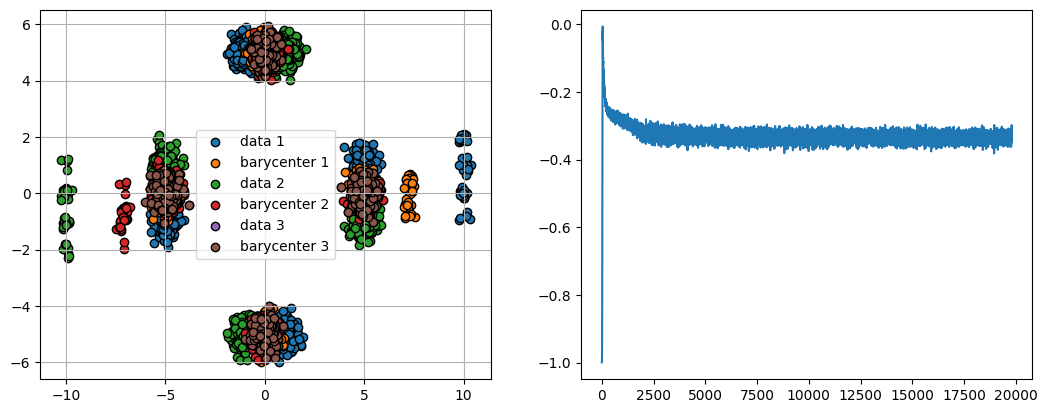

100%|██████████| 20000/20000 [53:28<00:00,  6.23it/s]


In [4]:
def train(
    maps: OTMap, maps_opt, maps_sched, 
    pots: Pots, pots_opt, pots_sched,
    mvalue, mvalue_opt, mvalue_sched,
    reg_coeff: float = 0.0, tau: float = 1.0,
    divergence: str = 'balanced',
):
    divergences = [divergence]*CONFIG.K
    losses = []
    for epoch in tqdm(range(CONFIG.NUM_EPOCHS)):
        
        freeze(pots)
        freeze(mvalue)
        unfreeze(maps)
        
        #inner loop
        for it in range(CONFIG.INNER_ITERATIONS):
            for n in range(1):
                # data sampling
                data = [
                    datas[k].sample([CONFIG.BATCH_SIZE]).to(CONFIG.DEVICE)
                    for k in range(CONFIG.K)
                ]

                maps_opt.zero_grad()
                loss = 0
                for k in range(CONFIG.K):
                    mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
                    cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
                    m = mvalue()
                    cost -= pots[k](mapped_x_k, m)  # [B, 1]
                    cost += reg_coeff * torch.unsqueeze(reg, -1)
                    cost = cost.mean(dim=0)
                    loss += CONFIG.LAMBDAS[k] * cost
                loss.backward()
                maps_opt.step()
                maps_sched.step()

        # unfreezing potentials 
        # freezing maps
        unfreeze(pots)
        if divergence != 'balanced':
            unfreeze(mvalue)
        freeze(maps)
        
        # outer optimiztion
        pots_opt.zero_grad()
        mvalue_opt.zero_grad()
        loss=0

        m = mvalue()
        cost = None
        for k in range(CONFIG.K):
            mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
            
            cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
            
            cost -= pots[k](mapped_x_k, m)  # [B, 1]
            if divergences[k] == 'kl':
                cost = - tau * (torch.exp(-cost/tau) - 1)
            elif divergences[k] == 'balanced':
                pass
            cost += reg_coeff * torch.unsqueeze(reg, -1)
            cost = cost.mean(dim=0)
            loss += CONFIG.LAMBDAS[k] * cost
        loss += m
        
        loss = -1*loss
        losses.append(loss.item())
        loss.backward()
        pots_opt.step()
        pots_sched.step()
        mvalue_opt.step()
        mvalue_sched.step()
        
        
        # plotting part
        if epoch % 200 ==0 :
            print(mvalue())
            data = [datas[k].sample([1_000]).to(CONFIG.DEVICE)
                        for k in range(CONFIG.K)]
            
            clear_output(wait=True)
            fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))
            for k in range(CONFIG.K):
                d = maps[k](data[k]).detach().cpu()
                ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(),edgecolor='black',label=f'data {k+1}')
                ax.scatter(d[:,0],d[:,1],edgecolor='black',label=f'barycenter {k+1}')
                ax.grid()
                ax.legend()
                # ax.set_xlim(-8, 8)
                # ax.set_ylim(-8, 8)
                
            ax_l.plot(losses)
            plt.show()

Tau = CONFIG.TAU

seed_everything(0, avoid_benchmark_noise=True)

maps_ur = nn.ModuleList([
    DeterministicMap(CONFIG.INPUT_DIM, CONFIG.HIDDEN_DIMS, CONFIG.OUTPUT_DIM_MAP)
    for _ in range(CONFIG.K)
]).to(CONFIG.DEVICE)
maps_opt, maps_sched = get_opt_sched(maps_ur, CONFIG.LR, CONFIG.NUM_EPOCHS * CONFIG.INNER_ITERATIONS)

pots_ur = get_pots(CONFIG)
pots_opt, pots_sched = get_opt_sched(pots_ur, CONFIG.LR, CONFIG.NUM_EPOCHS)

# add m
mvalue = MinValue().to(CONFIG.DEVICE)
mvalue_opt = torch.optim.Adam(mvalue.parameters(), CONFIG.LR, betas=(0., 0.9))
mvalue_sched = torch.optim.lr_scheduler.OneCycleLR(
        mvalue_opt,
        CONFIG.LR,
        total_steps=CONFIG.NUM_EPOCHS,
    )


train(maps_ur, maps_opt, maps_sched, pots_ur, pots_opt, pots_sched, mvalue, mvalue_opt, mvalue_sched, tau=Tau, divergence=CONFIG.DIVERGENCE)

In [8]:
# save transport maps
parent = 'ckpts/OUTLIERS'
EXP_DIR = os.path.join(parent, f'{CONFIG.DIVERGENCE}_{CONFIG.OUTLIER}_{CONFIG.TAU}')
os.makedirs(EXP_DIR, exist_ok=True)

for k, map in enumerate(maps_ur):
    torch.save(map.state_dict(), os.path.join(EXP_DIR, f'net{k}_epoch_{CONFIG.NUM_EPOCHS}.pth'))

torch.save(pots_ur.state_dict(), os.path.join(EXP_DIR, f'pots_epoch_{CONFIG.NUM_EPOCHS}.pth'))
torch.save(mvalue.state_dict(), os.path.join(EXP_DIR, f'mvalue_epoch_{CONFIG.NUM_EPOCHS}.pth'))

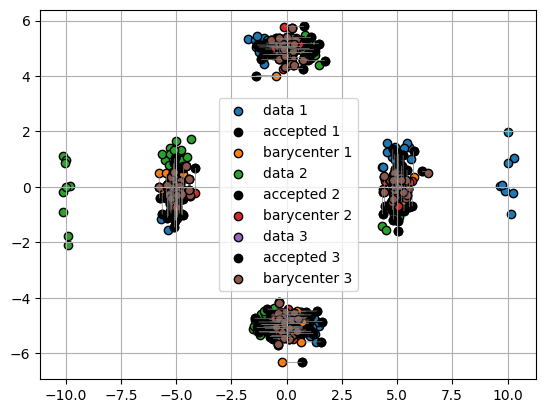

In [11]:
print('Tau=%d'%Tau)

divergences = [CONFIG.DIVERGENCE]*CONFIG.K
data = [datas[k].sample([128]).to(CONFIG.DEVICE) for k in range(CONFIG.K)]

TRAINED_BARYCENTERS = {}

clear_output(wait=True)
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for k in range(CONFIG.K):
    U = torch.rand(len(data[k]))
    mapped_x_k, _ = maps_ur[k](data[k], reg=True)  # [B, N]
    f_c = strong_cost(data[k], mapped_x_k)  # [B, 1]
    m = mvalue()
    f_c -= pots_ur[k](mapped_x_k, m)
    
    c = torch.max(torch.exp(-f_c/Tau)).cpu()

    if divergences[k] == 'balanced':
        print(k)
        acc = data[k]
    elif divergences[k] == 'kl':
        acc = data[k][U < 1/c * torch.exp(-f_c/Tau).flatten().detach().cpu()]
        rej = data[k][U >= 1/c * torch.exp(-f_c/Tau).flatten().detach().cpu()]
    
    mapped_x_k_acc, _ = maps_ur[k](acc, reg=True)
    
    TRAINED_BARYCENTERS[f'mu_{k}'] = acc.detach().cpu().numpy()
    TRAINED_BARYCENTERS[f'barycenter_{k}'] = mapped_x_k_acc.detach().cpu().numpy()

    ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(), edgecolor='black',label=f'data {k+1}')
    ax.scatter(acc[:,0].cpu(),acc[:,1].cpu(),color='black',edgecolor='black',label=f'accepted {k+1}')
    # if k==0:
    lines =  list(zip(acc.cpu().numpy(), mapped_x_k_acc.cpu().numpy()))
    lc = mc.LineCollection(lines, linewidths=0.5, color='gray', zorder=4)
    ax.scatter(mapped_x_k_acc[:,0].cpu(), mapped_x_k_acc[:,1].cpu(), edgecolor='black',label=f'barycenter {k+1}')
    ax.add_collection(lc)
    ax.grid()
    ax.legend()

plt.show()
# print(mvalue())